# **차량 공유업체의 차량 파손 여부 분류하기**

## 0.미션

* 1) 미션1 : Data Preprocessing
    - **과제 수행 목표**
        - 모델링 수행을 위해 적절한 폴더 및 파일로 **일관성 있게 정리**해야 합니다.
        - 제공된 데이터 : Car_Images.zip
            * Car_Images : 차량의 정상/파손 이미지 무작위 수집

* 2) 미션2 : CNN 모델링
    - **과제 수행 목표**
        - Keras를 이용하여 모델을 3개 이상 생성하세요.
            - 모델 구조와 파라미터는 자유롭게 구성하세요.
            - 단, 세부 목차에서 명시한 부분은 지켜주세요.

* 3) 미션3 : Transfer Learning
    - **과제 수행 목표**
        - 성능 개선을 위해 다음의 두가지를 시도하세요.
            * Image Preprocessing Layer, Image Augmentation Layer를 통해 이미지를 변형시켜 봅시다.
            * Transfer Learning(Inception V3)
* 성능 가이드
    * Accuracy : 0.34~0.74

## 1.환경설정

* **세부 요구사항**
    - 경로 설정 : Google Colaboratory의 가상 컴퓨터 안에 데이터셋을 다운로드 받고 압축을 해제하세요.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.

In [ ]:
!pip install keras --upgrade

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

### (1) 라이브러리 불러오기

In [ ]:
import gdown, zipfile
import os, glob, shutil
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

### (2) 데이터 불러오기

#### 1) 데이터 다운로드

In [ ]:
def download_file(file_id, save_path) :
    if os.path.exists(save_path) :
        print(f'{save_path} 파일이 이미 존재합니다.')
        return

    gdown.download(id=file_id, output=save_path, quiet=False)

In [ ]:
file_id = '1JHo4Rsb8Mx-sJqu7xdQWUgrfAf3H1g7W'

download_file(file_id, 'car_images.zip')

#### 2) 데이터 압축 해제

In [ ]:
def dataset_extract(file_name) :
    with zipfile.ZipFile(file_name, 'r') as zip_ref :
        file_list = zip_ref.namelist()

        if os.path.exists(f'./{file_name[:-4]}/') :
            print(f'데이터셋 폴더가 이미 존재합니다.')
            return

        else :
            for f in tqdm(file_list, desc='Extracting', unit='files') :
                zip_ref.extract(member=f, path=f'./{file_name[:-4]}/')

In [ ]:
dataset_extract('car_images.zip')

#### 2) 데이터 조회

In [ ]:
# 폴더별 이미지 데이터 갯수 확인
path = '/content/car_images/'

print(f"정상 차량 이미지 데이터는 {len(glob.glob(path+'normal/*'))}장 입니다.")
print(f"파손 차량 이미지 데이터는 {len(glob.glob(path+'abnormal/*'))}장 입니다.")

정상 차량 이미지 데이터는 302장 입니다.
파손 차량 이미지 데이터는 303장 입니다.


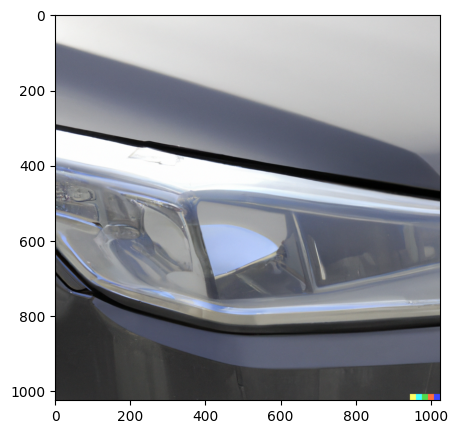

이미지 데이터의 형태는 다음과 같습니다 : (1024, 1024, 3)


In [ ]:
# 정상 차량 랜덤 이미지 확인 및 형태 확인

rand_n = np.random.randint( 0, len(glob.glob(path+'normal/*'))-1 )

plt.figure(figsize=(5,5))
img = plt.imread(glob.glob(path+'normal/*')[rand_n])
plt.imshow(img)
plt.show()

print(f'이미지 데이터의 형태는 다음과 같습니다 : {img.shape}')

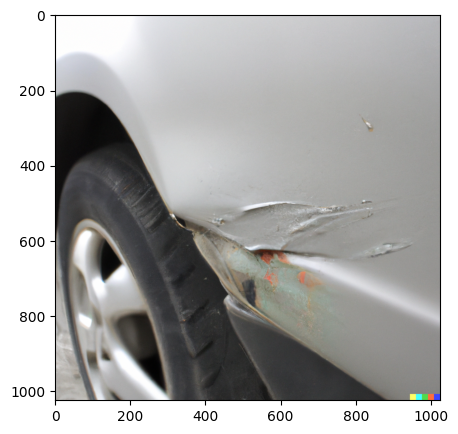

이미지 데이터의 형태는 다음과 같습니다 : (1024, 1024, 3)


In [ ]:
# 파손 차량 랜덤 이미지 확인 및 형태 확인

rand_n = np.random.randint( 0, len(glob.glob(path+'abnormal/*'))-1 )

plt.figure(figsize=(5,5))
img = plt.imread(glob.glob(path+'abnormal/*')[rand_n])
plt.imshow(img)
plt.show()

print(f'이미지 데이터의 형태는 다음과 같습니다 : {img.shape}')

## 2.데이터 전처리
* 모델링을 위한 데이터 구조 만들기
    * X : 이미지를 array로 변환합니다.
    * Y : 이미지 갯수만큼 normal - 0, abnormal - 1 로 array를 만듭니다.

### (1) Y : 클래스 만들기
- **세부요구사항**
    - 전체 데이터에 대한 Y를 생성합니다.
    - normal, abnormal 데이터의 수를 확인하고 normal을 0, abnormal을 1로 지정합니다.

In [ ]:
# 정상 이미지, 파손 이미지의 수 확인
len(glob.glob(path+'normal/*')), len(glob.glob(path+'abnormal/*'))

(302, 303)

In [ ]:
# 정상 이미지는 0, 파손 이미지는 1로 설정
y_normal = np.zeros((302,))
y_abnormal = np.ones((303,))

# 정상 데이터 어레이와 파손 데이터 어레이를 합침
y_total = np.hstack((y_normal, y_abnormal))

# 전체 y에 대한 형태 확인
y_total.shape

(605,)

### (2) X : 데이터 리스트 통합
- **세부요구사항**
    - 전체 이미지 데이터를 하나의 리스트로 통합합니다.

In [ ]:
x_total_list = glob.glob(path+'normal/*') + glob.glob(path+'abnormal/*')

In [ ]:
# x_total_list

### (3) 데이터셋 분리
- **세부요구사항**
    - 데이터 스플릿의 비율 (1) : train set, test set = 90%, 10%으로 설정하세요.
    - 데이터 스플릿의 비율 (2) : train set, valid set = 90%, 10%으로 설정하세요.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# training set, test set 분리
x_train, x_test, y_train, y_test =\
    train_test_split(x_total_list, y_total, test_size=0.1, random_state=2024)

In [ ]:
# training set, validation set 분리
x_train, x_val, y_train, y_val =\
    train_test_split(x_train, y_train, test_size=0.1, random_state=2024)

In [ ]:
# 데이터셋별 데이터 수 확인
len(x_train), y_train.shape, len(x_val), y_val.shape, len(x_test), y_test.shape

(489, (489,), 55, (55,), 61, (61,))

### (4) X : image to array
- **세부요구사항**
    * 모델링을 위해서는 np.array 형태로 데이터셋을 만들어야 합니다.
    * Training set / Validation set / Test set의 X는 이미지 형태로 되어있습니다.
    * 이미지 파일을 불러와 Training data, Validation data, Test data 각각 array 형태로 변환해 봅시다.

In [ ]:
import keras

In [ ]:
def x_preprocessing(img_list) :
    bin_list = []

    for img in tqdm(img_list) :
        img = keras.utils.load_img(img, target_size=(128,128), keep_aspect_ratio=True)
        img = keras.utils.img_to_array(img)
        bin_list.append(img)

    return np.array(bin_list)

In [ ]:
x_train_arr = x_preprocessing(x_train)
x_valid_arr = x_preprocessing(x_val)
x_test_arr = x_preprocessing(x_test)

print(x_train_arr.shape)
print(x_valid_arr.shape)
print(x_test_arr.shape)

100%|██████████| 61/61 [00:01<00:00, 35.12it/s]

(489, 128, 128, 3)
(55, 128, 128, 3)
(61, 128, 128, 3)


## 3.모델링 I
* **세부요구사항**
    * 모델을 최소 3개 이상 만들고 성능을 비교합니다.
        * 모델 학습 과정에 알맞은 보조 지표를 사용하세요.
        * 전처리 과정에서 생성한 Validation set을 적절하게 사용하세요.
        * Early Stopping을 반드시 사용하세요.
            * 최적의 가중치를 모델에 적용하세요.

### (1) 모델 1
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

In [ ]:
import keras

from keras.backend import clear_session
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix

#### 1) 구조 설계

In [ ]:
clear_session()

model1 = Sequential()

model1.add( Input(shape=(128,128,3) ))
model1.add( Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu') )
model1.add( Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu') )
model1.add( MaxPool2D(pool_size=(2,2)) )

model1.add( Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu') )
model1.add( Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu') )
model1.add( MaxPool2D(pool_size=(2,2)) )

# model1.add( Flatten() )
model1.add( keras.layers.GlobalAvgPool2D() )
model1.add( Dense(1, activation='sigmoid') )

model1.compile(loss=keras.losses.binary_crossentropy, metrics=['accuracy'],
               optimizer='adam')

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 256)       │          19,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 256)       │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,100,865 (8.01 MB)

 Trainable params: 2,100,865 (8.01 MB)

 Non-trainable params: 0 (0.00 B)

#### 2) 학습

In [ ]:
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   verbose=1,
                   patience=5,
                   restore_best_weights=True)

In [ ]:
mcp = ModelCheckpoint('/content/model1.keras',
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True,
                      save_weights_only=False)

In [ ]:
x_train_arr.shape, y_train.shape

In [ ]:
hist1 = model1.fit(x_train_arr, y_train, epochs=100, verbose=1, batch_size=16,
                   validation_data=(x_valid_arr, y_val),
                   callbacks=[es, mcp]
                   )

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5204 - loss: 36.2361   
Epoch 1: val_loss improved from inf to 0.68514, saving model to /content/model1.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.5206 - loss: 35.4977 - val_accuracy: 0.5455 - val_loss: 0.6851
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.6119 - loss: 0.6615
Epoch 2: val_loss did not improve from 0.68514
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 290ms/step - accuracy: 0.6137 - loss: 0.6604 - val_accuracy: 0.5818 - val_loss: 0.9257
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7043 - loss: 0.6392
Epoch 3: val_loss did not improve from 0.68514
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 291ms/step - accuracy: 0.7036 - loss: 0.6390 - val_accuracy: 0.6545 - val_loss: 0.9633
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.7334 - loss: 0.5504
Epoch 4: val_loss did not improve from 0.68514
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step - accuracy: 0.7335 - loss: 0.549

#### 3) 성능 평가
* 평가는 confusion_matrix, classification_report 활용

In [ ]:
# 예측
y_pred1 = model1.predict(x_test_arr)

# 0, 1로 변환
y_pred1 = np.where(y_pred1 >= 0.5, 1, 0)

2/2 ━━━━━━━━━━━━━━━━━━━━ 67s 32s/step


In [ ]:
y_pred1.reshape((-1))

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
# 평가하기
print(confusion_matrix(y_test, y_pred1))
print(classification_report(y_test, y_pred1, target_names=['normal', 'abnormal']))

[[ 3 30]
 [ 0 28]]
              precision    recall  f1-score   support

      normal       1.00      0.09      0.17        33
    abnormal       0.48      1.00      0.65        28

    accuracy                           0.51        61
   macro avg       0.74      0.55      0.41        61
weighted avg       0.76      0.51      0.39        61



## 4.모델링 II
* **세부요구사항**
    - image_dataset_from_directory를 이용하여 training set, validation set을 만들어봅시다.
    - 성능을 높이기 위해서 다음의 두가지를 시도해 봅시다.
        - Image Preprocessing Layer, Image Augmentation Layer를 통해 이미지를 변형시켜 봅시다.
        - 사전 학습된 모델(Transfer Learning)을 가져다 사용해 봅시다.

### (1) image_dataset_from_directory

In [ ]:
from keras.utils import image_dataset_from_directory

In [ ]:
idfd_train, idfd_valid = image_dataset_from_directory('/content/car_images/',
                                                      label_mode='binary',
                                                      image_size=(128,128),
                                                      shuffle=True,
                                                      seed=2024,
                                                      validation_split=0.2,
                                                      subset='both'
                                                      )

Found 605 files belonging to 2 classes.
Using 484 files for training.
Using 121 files for validation.


### (2) Transfer Learning

#### 1) Inception V3 모델을 불러와서 저장하기
* include_top=False로 설정하여 분류기를 제외하고 미리 학습된 가중치 imagenet을 로드합니다.
* .trainable을 False로 설정하여 불러온 모델의 모든 레이어들을 Frozen 시켜 가중치를 고정합니다.

In [ ]:
import keras

from keras.applications.inception_v3 import InceptionV3

In [ ]:
base_model = InceptionV3(include_top=False,
                         weights='imagenet',
                         input_shape=(128,128,3)
                         )
base_model.trainable = False

#### 2) Inception V3 모델과 연결하여 구조 설계
* Inception V3을 불러온 후, 다른 레이어와 연결하기
* Image Preprocessing Layer, Image Augmentation Layer를 사용해보세요.

In [ ]:
keras.utils.clear_session()

i_l = keras.layers.Input(shape=(128,128,3))
aug = keras.layers.Rescaling(1./255)(i_l)
aug = keras.layers.RandomFlip()(aug)
aug = keras.layers.RandomRotation(0.2)(aug)

base = base_model(aug)

h_l = keras.layers.GlobalAvgPool2D()(base)
o_l = keras.layers.Dense(1, activation='sigmoid')(h_l)

model2 = keras.models.Model(i_l, o_l)
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,804,833 (83.18 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
model2.compile(optimizer='adam', loss='binary_crossentropy',
               metrics=['accuracy'])

#### 3) 학습

In [ ]:
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   verbose=1,
                   patience=5,
                   restore_best_weights=True)

In [ ]:
mcp = ModelCheckpoint('/content/model2.keras',
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True,
                      save_weights_only=False)

In [ ]:
x_train_arr.shape, y_train.shape

In [ ]:
hist2 = model2.fit(idfd_train, validation_data=idfd_valid,
                   epochs=100, verbose=1,
                   callbacks=[es]
                   )

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 780ms/step - accuracy: 0.5909 - loss: 0.8643 - val_accuracy: 0.7273 - val_loss: 0.5270
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 481ms/step - accuracy: 0.8038 - loss: 0.4822 - val_accuracy: 0.8182 - val_loss: 0.3953
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 482ms/step - accuracy: 0.8232 - loss: 0.3844 - val_accuracy: 0.8760 - val_loss: 0.3253
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 506ms/step - accuracy: 0.8435 - loss: 0.3692 - val_accuracy: 0.8678 - val_loss: 0.3024
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 478ms/step - accuracy: 0.8576 - loss: 0.3342 - val_accuracy: 0.8843 - val_loss: 0.2758
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 425ms/step - accuracy: 0.8597 - loss: 0.3200 - val_accuracy: 0.8843 - val_loss: 0.2614
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 418ms/step - accuracy: 0.8694 - loss: 0.3169 - val_accuracy: 0.8182 - val_loss: 0.3064
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 412ms/step - accuracy: 0.8802 - loss: 0.3397 - 

#### 4) 성능 평가

In [ ]:
# 예측
y_pred2 = model2.predict(x_test_arr)

# 0, 1로 변환
y_pred2 = np.where(y_pred2 >= 0.5, 1, 0)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [ ]:
y_pred2.reshape((-1))

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1])

In [ ]:
# 평가하기
print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2, target_names=['normal', 'abnormal']))

[[ 3 30]
 [26  2]]
              precision    recall  f1-score   support

      normal       0.10      0.09      0.10        33
    abnormal       0.06      0.07      0.07        28

    accuracy                           0.08        61
   macro avg       0.08      0.08      0.08        61
weighted avg       0.08      0.08      0.08        61

